In [158]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support
from train_utils import compute_metrics
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_auc_score

In [198]:
dfs = []
upstreams = ['wav2vec2', '_hubert', 'distilhubert', 'xlsr_53', 'unispeech', 'xls_r', 'wavlm' ]

paths = list(Path('../../result/').rglob('metrics_table_test.pickle'))+ \
list(Path('../../result_ene_27/').rglob('metrics_table_test.pickle'))+ \
list(Path('../../result_tullamore/').rglob('metrics_table_test.pickle'))+ \
list(Path('../../result_ene_24_timit2A/').rglob('metrics_table_test.pickle'))+\
list(Path('../../result_ene_20_useme/').rglob('metrics_table_test.pickle'))
print
for p in paths:
    name = p.parts[-2]
    path = p.parts[-4]
    df = pd.read_pickle(p)
    if not 'timit_' in name and not 'testigo' in name and not 'v2' in name:
        trampa = False
        if isinstance(df.iloc[0]['F1Score'],np.ndarray):
            df['F1Score'] = df['F1Score'].map(max)
            trampa = True
            print('F1 TRAMPA',name)
        
        df['name']=name
        df['path']=path
        
        df['db'] = 'l2arctic' if 'l2arctic' in name else 'epadb'
        df['phone_rec'] = True if 'timit2A' in name else False
        df['ft'] = True if '_ft' in name else False
        for up in upstreams:
            if up in name:
                df['upstream'] = up
                
        if 'linear' in name:
            df['upstream']+='+linear'
        if trampa:
            df['upstream']+='+TRAMPA'
        df = df.set_index(['phone_rec', 'upstream','ft','db'],append=True)
        df = df.swaplevel(0,-1)
        dfs.append(df)
df = pd.concat(dfs)
df = df[df.index.get_level_values(4)!=0]

F1 TRAMPA l2arctic_hubert_linear_npc_ft
F1 TRAMPA l2arctic_hubert_linear_cw
F1 TRAMPA epa_hubert_linear_npc
F1 TRAMPA epa_hubert_linear_lpp
F1 TRAMPA epa_hubert_linear_softmin
F1 TRAMPA l2arctic_hubert_linear_npc
F1 TRAMPA epa_hubert_linear_min
F1 TRAMPA l2arctic_hubert_linear_min
F1 TRAMPA l2arctic_hubert_linear_lpp
F1 TRAMPA epa_hubert_linear_ns
F1 TRAMPA l2arctic_hubert_linear_min_ft
F1 TRAMPA epa_hubert_linear_cw
F1 TRAMPA epa_hubert_linear_npc_ft
F1 TRAMPA epa_hubert_linear_min_ft
F1 TRAMPA l2arctic_hubert_linear_cw_ft
F1 TRAMPA epa_hubert_linear_ns_ft
F1 TRAMPA l2arctic_hubert_linear_ns
F1 TRAMPA l2arctic_hubert_linear_softmin_ft
F1 TRAMPA epa_hubert_linear_lpp_ft
F1 TRAMPA l2arctic_hubert_linear_ns_ft
F1 TRAMPA epa_hubert_linear_cw_ft
F1 TRAMPA l2arctic_hubert_linear_lpp_ft
F1 TRAMPA epa_hubert_linear_softmin_ft
F1 TRAMPA l2arctic_hubert_linear_softmin


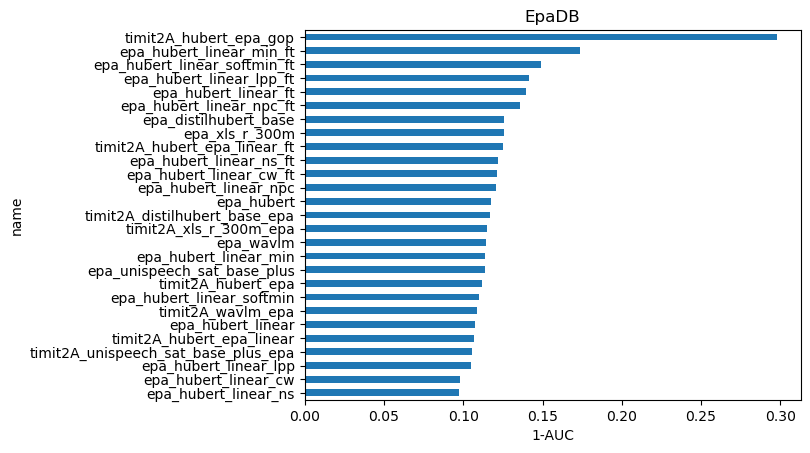

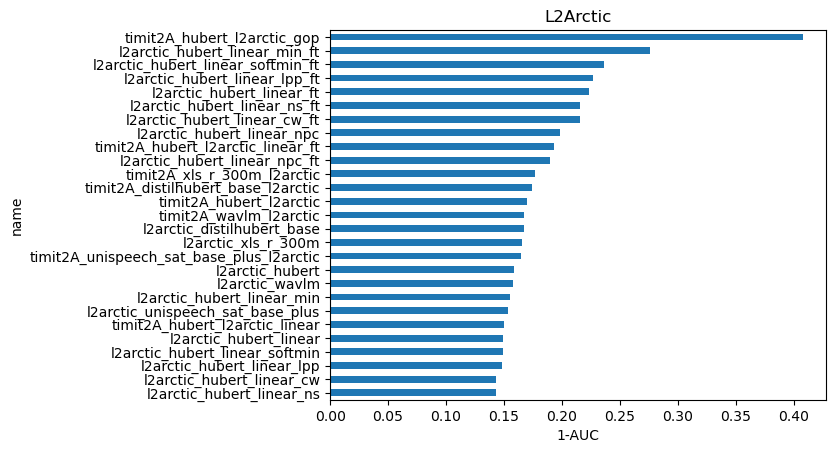

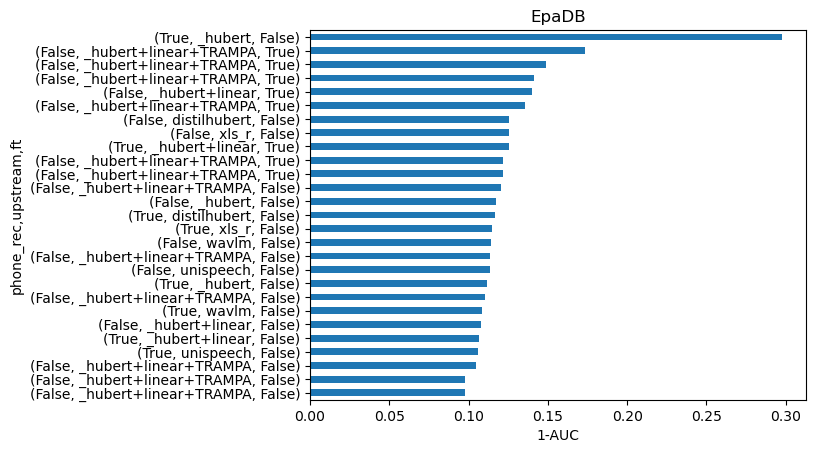

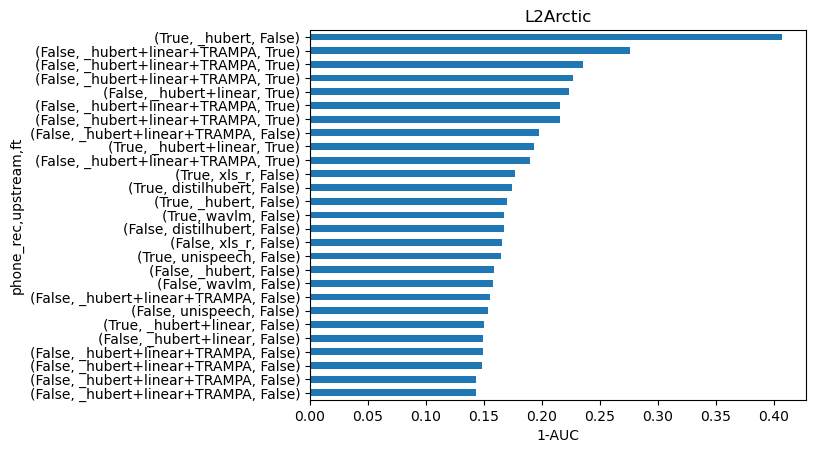

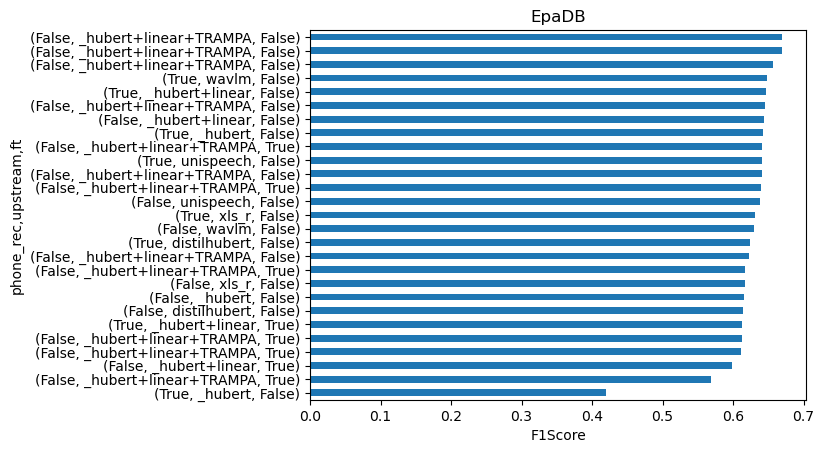

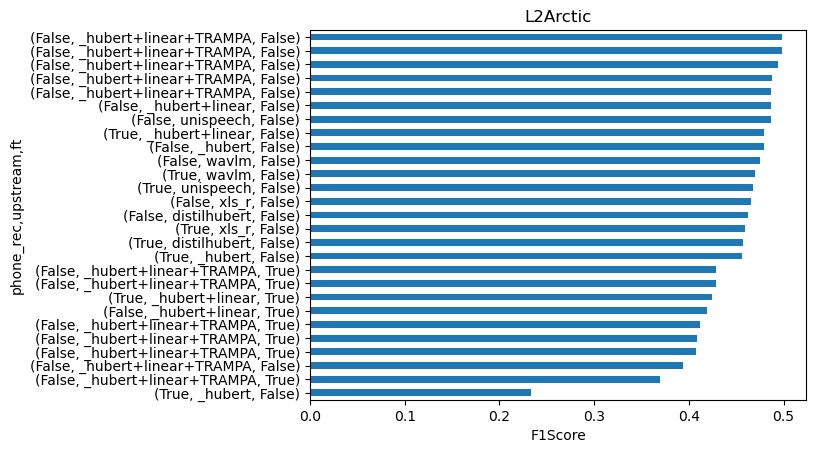

In [202]:
plt.figure()
df.xs('epadb',level=0).xs('all', level=3).set_index('name')['1-AUC'].sort_values().plot.barh();
plt.xlabel('1-AUC')
plt.title('EpaDB');
plt.figure()
df.xs('l2arctic',level=0).xs('all', level=3).set_index('name')['1-AUC'].sort_values().plot.barh();
plt.xlabel('1-AUC')
plt.title('L2Arctic');

plt.figure()
df.xs('epadb',level=0).xs('all', level=3)['1-AUC'].sort_values().plot.barh();
plt.xlabel('1-AUC')
plt.title('EpaDB');
plt.figure()
df.xs('l2arctic',level=0).xs('all', level=3)['1-AUC'].sort_values().plot.barh();
plt.xlabel('1-AUC')
plt.title('L2Arctic');

plt.figure()
df.xs('epadb',level=0).xs('all', level=3)['F1Score'].sort_values().plot.barh();
plt.xlabel('F1Score')
plt.title('EpaDB');
plt.figure()
df.xs('l2arctic',level=0).xs('all', level=3)['F1Score'].sort_values().plot.barh();
plt.title('L2Arctic');
plt.xlabel('F1Score');

In [176]:
# dfs = []
# upstreams = ['wav2vec2', 'hubert', 'xlsr_53']
# for p in Path('../../result_ene_20_useme/').rglob('metrics_table_test.pickle'):
#     name = p.parts[-2]
#     df = pd.read_pickle(p)
#     df['name']=name
#     df['db'] = 'l2arctic' if 'l2arctic' in name else 'epadb'
#     df['nonnative_train'] = False if 'timit' in name else True
#     df['ft'] = True if '_ft' in name else False
#     for up in upstreams:
#         if up in name:
#             df['upstream'] = up    
#     df = df.set_index(['nonnative_train', 'upstream','ft','db'],append=True)
#     df = df.swaplevel(0,-1)
#     dfs.append(df)
# df = pd.concat(dfs)
# df = df[df.index.get_level_values(4)!=0]

In [104]:
# df[df.index.get_level_values(4)!='all'].groupby('name')['F1Score'].mean().sort_values().plot.barh();
# plt.xlim(0.8,0.93);

In [56]:
# df[df.index.get_level_values(4)!='all'].groupby('name')['1-AUC'].mean().sort_values().plot.barh();

In [94]:
def kdeplots(paths, texts):
    f, axs = plt.subplots(int(np.round(len(texts)/2)),2,figsize=(8, len(texts)*2))
    axs = axs.ravel()
    for i,(txt, path) in enumerate(zip(texts, paths)):
        ax = axs[i]
        dfx = pd.read_pickle(path+'/data_for_eval_dev.pickle')
        dfx = dfx[dfx['phone_automatic']!=0]     
        
        d = compute_metrics(dfx)
        ix = np.nanargmax(d['F1Score'])
        dev_best_f1_thr = d['F1Thr'][ix]
        dfx = pd.read_pickle(path+'/data_for_eval_test.pickle')
        dfx = dfx[dfx['phone_automatic']!=0]
        
        d = compute_metrics(dfx, f1_thr=dev_best_f1_thr)    
        sns.kdeplot(dfx,hue='label', x='gop_scores', ax = axs[i], common_norm=False);
        auc = roc_auc_score(dfx['label'], dfx['gop_scores'])
        ax.vlines(dev_best_f1_thr,0,ax.get_yticks()[-1], color='k')
        ax.set_title(f'{txt}\nAUC: {auc:0.2} F1Thr: {dev_best_f1_thr:0.2}\n R: {d["Recall"]:0.2} P: {d["Precision"]:0.2} F1: {d["F1Score"]:0.2} ')

    plt.tight_layout()

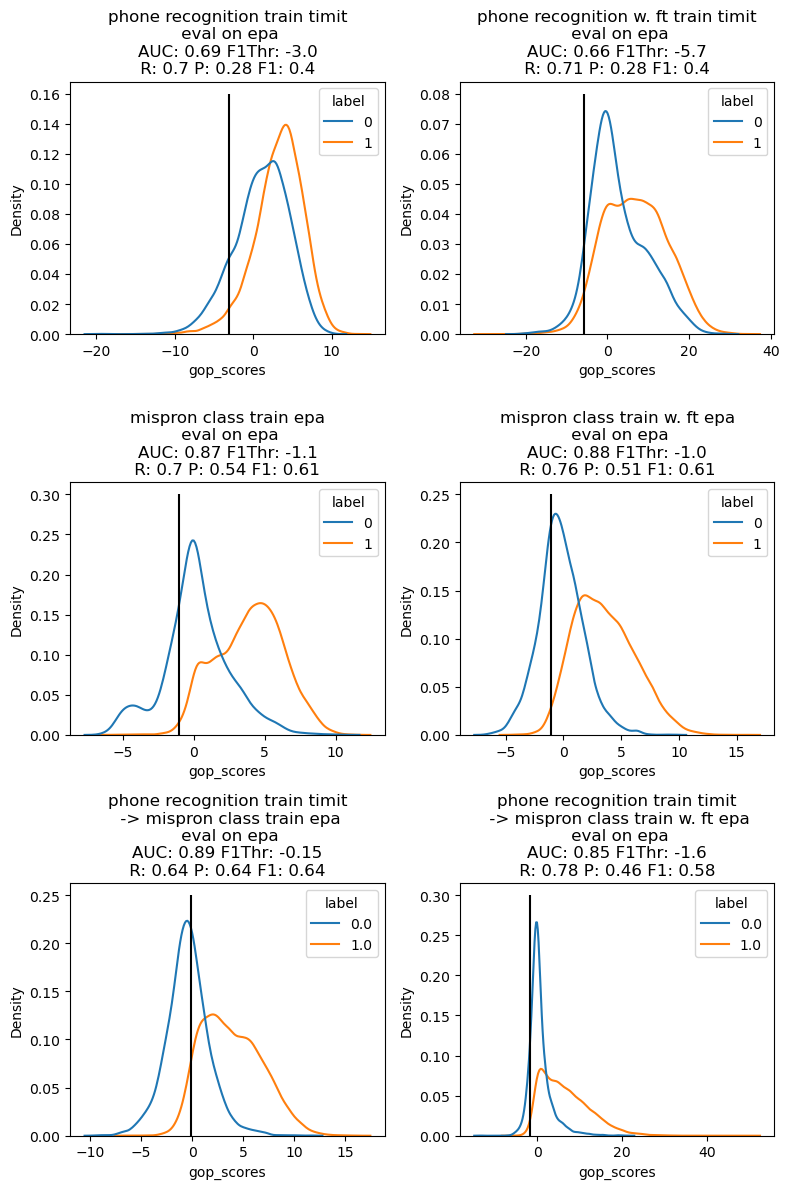

In [95]:
paths = ['../../result_ene_20_useme/downstream/timit_hubert_epa/', 
         '../../result_ene_20_useme/downstream/timit_hubert_ft_epa/',
         '../../result_ene_20_useme/downstream/epa_hubert_ft/', 
         '../../result_ene_20_useme/downstream/epa_hubert/', 
         '../../result_ene_24_timit2A/downstream/timit2A_hubert_epa/',
         '../../result/downstream/timit2A_hubert_epa_ft/'
        ]
texts = ['phone recognition train timit\n eval on epa',
         'phone recognition w. ft train timit\n eval on epa',
         'mispron class train epa\n eval on epa',
         'mispron class train w. ft epa\n eval on epa',
         'phone recognition train timit\n -> mispron class train epa\n eval on epa',
         'phone recognition train timit\n -> mispron class train w. ft epa\n eval on epa',
    ]
kdeplots(paths, texts)

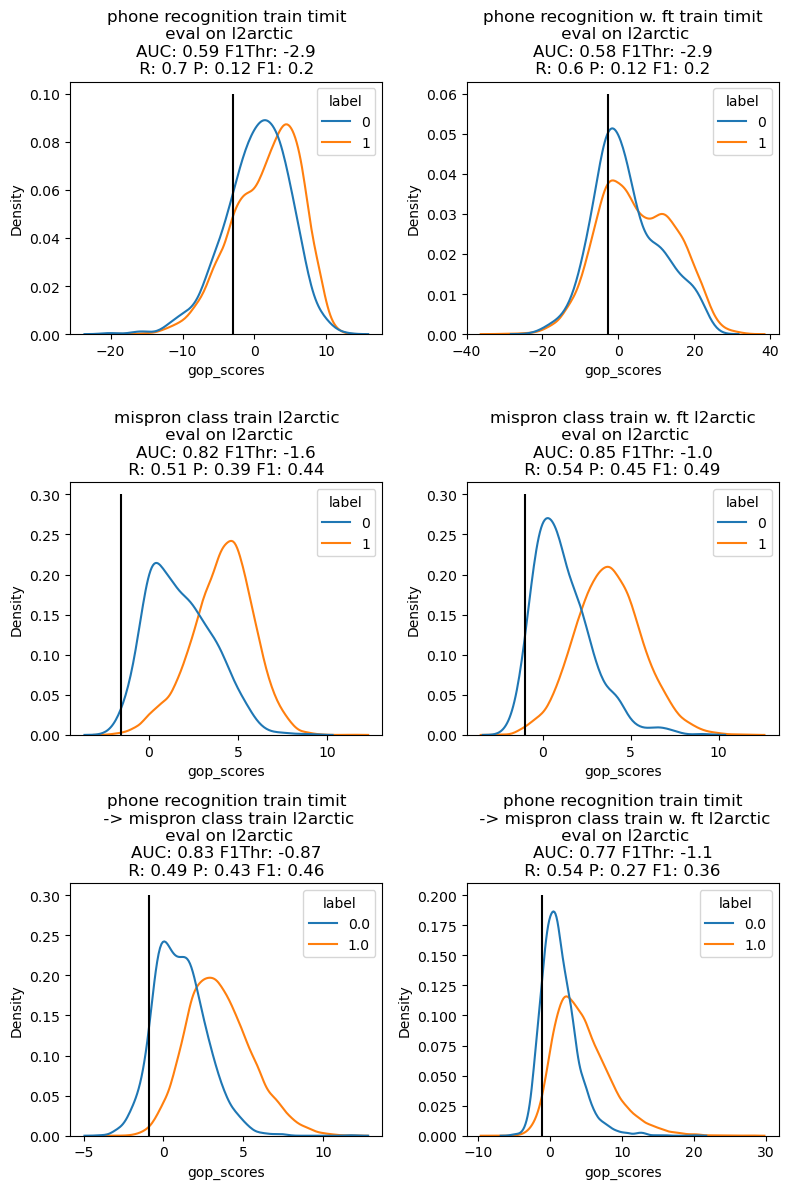

In [96]:
paths = ['../../result_ene_20_useme/downstream/timit_hubert_l2arctic/', 
         '../../result_ene_20_useme/downstream/timit_hubert_ft_l2arctic/',
         '../../result_ene_20_useme/downstream/l2arctic_hubert_ft/', 
         '../../result_ene_20_useme/downstream/l2arctic_hubert/', 
         '../../result_ene_24_timit2A/downstream/timit2A_hubert_l2arctic/',
         '../../result/downstream/timit2A_hubert_l2arctic_ft/']
        
texts = ['phone recognition train timit\n eval on l2arctic',
         'phone recognition w. ft train timit\n eval on l2arctic',
         'mispron class train l2arctic\n eval on l2arctic',
         'mispron class train w. ft l2arctic\n eval on l2arctic',
         'phone recognition train timit\n -> mispron class train l2arctic\n eval on l2arctic',
         'phone recognition train timit\n -> mispron class train w. ft l2arctic\n eval on l2arctic'
    ]
kdeplots(paths, texts)

In [3]:
# dfx = pd.read_pickle('../../result_ene_20_useme/downstream/l2arctic_wav2vec2_ft/data_for_eval_dev.pickle')
# dfy = pd.read_pickle('../../result_ene_20_useme/downstream/l2arctic_wav2vec2_ft/data_for_eval_test.pickle')

In [10]:
# precision, recall, f1_thr = precision_recall_curve(dfx['label'], dfx['gop_scores'], pos_label=1)
# numerator = 2 * recall * precision
# denom = recall + precision
# f1_scores = np.divide(numerator, denom, out=np.zeros_like(denom), where=(denom != 0))
# plt.plot(f1_thr, f1_scores[:-1])
# plt.plot(f1_thr, precision[:-1])
# plt.plot(f1_thr, recall[:-1])
# plt.ylim(0.8,1)

# precision, recall, f1_thr = precision_recall_curve(dfy['label'], dfy['gop_scores'], pos_label=1)
# numerator = 2 * recall * precision
# denom = recall + precision
# f1_scores = np.divide(numerator, denom, out=np.zeros_like(denom), where=(denom != 0))
# plt.plot(f1_thr, f1_scores[:-1])
# plt.plot(f1_thr, precision[:-1])
# plt.plot(f1_thr, recall[:-1])
# plt.ylim(0.8,1)

In [11]:
# dfx = pd.read_pickle('../../result_ene_20_useme/downstream/timit_hubert_ft_l2arctic/data_for_eval_test.pickle')
# dfy = pd.read_pickle('../../result_ene_20_useme/downstream/l2arctic_hubert_ft/data_for_eval_test.pickle')
# dfx = dfx[dfx['phone_automatic']!=0]
# dfy= dfy[dfy['phone_automatic']!=0]

# precision, recall, f1_thr = precision_recall_curve(dfx['label'], dfx['gop_scores'], pos_label=1)
# numerator = 2 * recall * precision
# denom = recall + precision
# f1_scores = np.divide(numerator, denom, out=np.zeros_like(denom), where=(denom != 0))
# plt.plot(f1_thr, f1_scores[:-1])
# plt.ylim(0.8,1)

# precision, recall, f1_thr = precision_recall_curve(dfy['label'], dfy['gop_scores'], pos_label=1)
# numerator = 2 * recall * precision
# denom = recall + precision
# f1_scores = np.divide(numerator, denom, out=np.zeros_like(denom), where=(denom != 0))
# plt.plot(f1_thr, f1_scores[:-1])
# plt.ylim(0.75,1);

In [12]:
# f1maxs1 = np.ones(40)
# f1maxs1[:]=np.nan

# for k, g1 in dfx.groupby('phone_automatic'):
#     if len(g1)>0:
#         precision, recall, f1_thr = precision_recall_curve(g1['label'], g1['gop_scores'], pos_label=1)
#         numerator = 2 * recall * precision
#         denom = recall + precision
#         f1_scores = np.divide(numerator, denom, out=np.zeros_like(denom), where=(denom != 0))
#         f1maxs1[k] = np.max(f1_scores) 
# plt.plot(f1maxs1,'o',  mfc='none');
      
# f1maxs2 = np.zeros(40)
# f1maxs2[:]=np.nan

# for k, g2 in dfy.groupby('phone_automatic'):
#     if len(g2)>0:
#         precision, recall, f1_thr = precision_recall_curve(g2['label'], g2['gop_scores'], pos_label=1)
#         numerator = 2 * recall * precision
#         denom = recall + precision
#         f1_scores = np.divide(numerator, denom, out=np.zeros_like(denom), where=(denom != 0))
#         f1maxs2[k] = np.max(f1_scores) 
# plt.plot(f1maxs2,'o', mfc='none');
# # plt.plot(f1maxs1-f1maxs2,'o', mfc='none');
# # np.nanmean(f1maxs1), np.nanmean(f1maxs2)

# plt.plot(df[(df.index.get_level_values(4)!='all') & (df['name']=='l2arctic_hubert_ft')]['F1Score'].index.get_level_values(4), df[(df.index.get_level_values(4)!='all') & (df['name']=='l2arctic_hubert_ft')]['F1Score'].values,'x', mfc='none');

In [13]:
# df[(df.index.get_level_values(4)!='all') & (df['name']=='l2arctic_hubert_ft')]['F1Score'].mean()

In [14]:
# df[df.index.get_level_values(4)!='all'].groupby('name')['F1Score'].mean().loc['l2arctic_hubert_ft']

In [15]:
# df[df.index.get_level_values(4)!='all'].groupby('name')['F1Score'].mean().loc['timit_hubert_ft_l2arctic']

In [16]:
# df[df['name']=='l2arctic_hubert_ft'].xs('all', level=4)['F1Score'].iloc[0]

In [17]:
# df[df['name']=='timit_hubert_ft_l2arctic'].xs('all', level=4)['F1Score'].iloc[0]

In [18]:
# dfx.boxplot(column='gop_scores',by='label');

In [19]:
# precision, recall, f1_thr = precision_recall_curve(dfx['label'], dfx['gop_scores'], pos_label=1)
# numerator = 2 * recall * precision
# denom = recall + precision
# f1_scores = np.divide(numerator, denom, out=np.zeros_like(denom), where=(denom != 0))
# plt.plot(f1_thr, f1_scores[:-1])
# plt.plot(f1_thr, precision[:-1])
# plt.plot(f1_thr, recall[:-1])
# plt.ylim(0.8,1);

In [20]:
# df.xs('all', level=4)['F1Thr']